<a href="https://colab.research.google.com/github/hayakzan/MLP-notations/blob/main/MLP_notations_GENERATING_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Before running the code
#### - Upload the notation fonts `/fonts/OpusStd.ttf` and `/fonts/OpusSpecialStd.ttf` into `/content` folder
#### - Upload `/xydata/train_xy.json` into `/content` folder


In [8]:
# -*- coding: utf-8 -*-

# dependencies
from __future__ import division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import random
from matplotlib.lines import Line2D
from scipy import interpolate
import csv
import pandas as pd
import json


In [19]:
global fig_num
fig_num = 1

font_dirs = ["/content"]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

fontprop1 = fm.FontProperties(fname=font_files[1], size=24)
fontprop2 = fm.FontProperties(fname=font_files[0], size=25)



#### Create a JSON file for the parameters

In [10]:
# Create a list to store the slider values
slider_values_list = []

# Function to update the slider values
def update_slider_values(change):
    # Create a dictionary to store the slider values
    slider_values = {
        "speed": speed_slider.value,
        "size": size_slider.value,
        "range_low": range_slider.value[0],
        "range_hi": range_slider.value[1],
        "x_offset": x_offset_slider.value,
        "y_offset": y_offset_slider.value,
        "rhy_irr": irregularity_slider.value
        "chord_num": chord_num_slider.value
        "chord_size": chord_size_slider.value
    }

    # Append the slider values to the list
    slider_values_list.append(slider_values)

    # Write the updated data to the file
    with open("slider_values.json", "w") as file:
        json.dump(slider_values_list, file, indent=4)


#### Use the sliders to set up notational parameters


In [90]:
import ipywidgets as widgets
from IPython.display import display

layout = widgets.Layout(margin='0 0 10px 0', width='40%')

# Create a slider widget
speed_slider = widgets.FloatSlider(value=1.0, min=0.2, max=2.0, step=0.1, description='speed:', style={'description_width': '150px'}, layout=layout)
size_slider = widgets.IntSlider(value=8, min=2, max=12, step=1, description='size:', style={'description_width': '150px'}, layout=layout)
range_slider = widgets.IntRangeSlider(value=[0, 12], min=0, max=12, step=1, description='range:', style={'description_width': '150px'}, layout=layout)
x_offset_slider = widgets.FloatSlider(value=0.25, min=0.25, max=7.0, step=0.05, description='x offset:', style={'description_width': '150px'}, layout=layout)
y_offset_slider = widgets.FloatSlider(value=0.0, min=-4.0, max=4.0, step=0.5, description='y offset:', style={'description_width': '150px'}, layout=layout)
irregularity_slider = widgets.FloatSlider(value=0.0, min=0.0, max=0.5, step=0.01, description='rhythmic irregularity:', style={'description_width': '150px'}, layout=layout)
chord_num_slider = widgets.IntSlider(value=0, min=0, max=size_slider.value, step=1, description='# of chords:', style={'description_width': '150px'}, layout=layout)
chord_size_slider = widgets.IntSlider(value=1, min=1, max=4, step=1, description='chord size:', style={'description_width': '150px'}, layout=layout)
chord_type_button = widgets.ToggleButtons(options=['Secundal', 'Tertian', 'Quartal', 'Mixed', 'Mixed within chord'], description='chord type:', disabled=False, button_style='info')
direction_box = widgets.ToggleButtons(options=['Mixed', 'Upwards', 'Downwards'], description='directionality:', disabled=False, button_style='info')
#poly_box = widgets.Checkbox(value=False, description='toggle polyphony', disabled=False, indent=True, layout=layout)

slider_box = widgets.VBox([speed_slider, size_slider, range_slider, x_offset_slider, y_offset_slider, irregularity_slider, chord_num_slider, chord_size_slider, chord_type_button, direction_box])

# Display the slider widget
display(slider_box)


#### After the initial run, run after here (`Cmd/Ctrl+F10`) after each new slider setting (no need to re-run the slider cell). This will add new data into `slider_values.json`

In [23]:
# constants & variables
seed_value = 1234
np.random.seed(seed_value)

phan_off = 0.25
x_off = x_offset_slider.value
y_off = 0.0

# staff lines
X_1, Y_1 = np.linspace(0.06, 10.345, 10), np.zeros(10)
# measure lines
X_2, Y_2 = np.linspace(0.06, 0.06, 10), np.linspace(4, 0, 10)
# phantoms
phantoms = [1, 2, 2.5, 3, 4, 5, 6, 7, 8]

# notes:
noteheads = ['f']
notes = []
accidentals = []
acc_sym = ['n','#','b']

notes.append(noteheads[0])

# arrays for data:
rhy_map = []
pi_map = []



In [13]:
# dicts
pha_dict = {1: phan_off, 2: 1.235 + phan_off, 2.5: (1.235 + 0.6175) + phan_off, 3: (1.235 * 2) + phan_off, 4: (1.235 * 3) + phan_off, 5: (1.235 * 4) + phan_off, 6: (1.235 * 5) + phan_off, 7: (1.235 * 6) + phan_off, 8: (1.235 * 7) + phan_off}


In [14]:
def paramMapping(pos, maptype, mini, maxi, rnd):
    min_pos = min(pos)
    max_pos = max(pos)
    if min_pos == max_pos:
        # Handle case when all input values are the same
        mapped_value = round((mini + maxi) / 2, rnd)
        maptype.extend([mapped_value] * len(pos))
    else:
        for i in range(size):
            mapped_value = round((maxi - mini) * ((pos[i] - min_pos) / (max_pos - min_pos)) + mini, rnd)
            maptype.append(mapped_value)


In [15]:
## input etc. TODO: dataset input option

size = size_slider.value

#raw_data = pd.read_csv("/content/src/pix.csv", converters={"0": int})
#chars = raw_data["0"].values.tolist()

# Generate random values
range_slider_min = range_slider.value[0]
range_slider_max = range_slider.value[1]
raw_data = np.random.randint(low=range_slider_min, high=range_slider_max, size=size)


In [16]:
## Speed / rhythmic irregularity / textural direction

speed = speed_slider.value
mean = 0
std_dev = irregularity_slider.value

x_data = list(range(size))
# Add randomness
x_data = [x + np.random.normal(mean, std_dev) for x in x_data]
x_data = [i*speed for i in x_data]

y_data = raw_data

if direction_box.value == 'Mixed':
  pass
elif direction_box.value == 'Upwards':
  y_data = sorted(raw_data)
elif direction_box.value == 'Downwards':
  y_data = sorted(raw_data, reverse=True)
else:
    pass


# print("x_data: ", x_data)
# print("y_data: ", y_data)

In [17]:
# perform mapping
# paramMapping(x_pos, rhy_map, 0.15, 1.85, 2)
# paramMapping(y_pos, pi_map, 68.0, 70.0, 0)
phan = [pha_dict[i] for i in phantoms] #do we need a dictionary for phantoms?
# pitches = [pitch_dict[i] for i in y_data]
pitches = y_data

# print("pitches: ", pitches)
# print("rhythms: ", x_data)
acc_sym[:2]

pitches:  [3 6 5 4 8 9 1 7]


['n', '#']

#### Generate the notation

pitches:  8
acc[j]:  b
pitches:  5
acc[j]:  b
pitches:  3
acc[j]:  #
pitches:  4
acc[j]:  n
pitches:  7
acc[j]:  n
pitches:  1
acc[j]:  b
pitches:  6
acc[j]:  #
pitches:  9
acc[j]:  n
accidentals:  ['b', 'b', '#', 'n', 'n', 'b', '#', 'n']


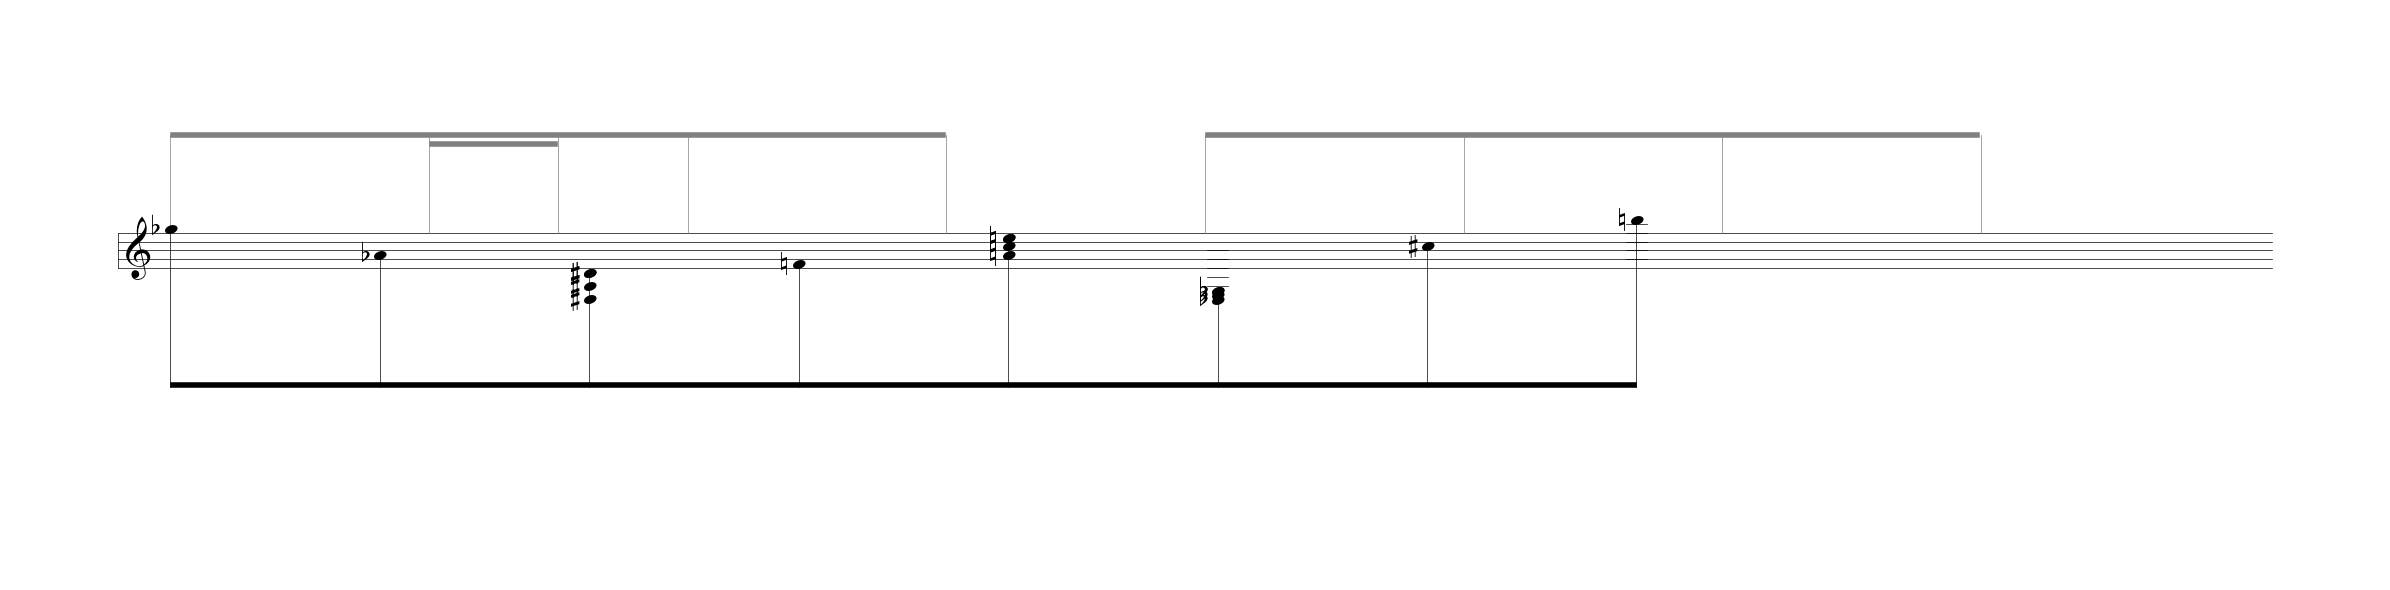

In [115]:
import warnings

# create the figure and subplot:
fig = plt.figure(figsize=(24, 6))
ax = plt.subplot(1, 1, 1)

# customize the subplot spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

accidentals = []
for j in range(size):
    # no sharps on Es in this context
    if pitches[j] % 3.5 == 0.0:
      accidentals.append(random.choice([acc_sym[0], acc_sym[2]]))
    # no flats on Fs in this context
    elif pitches[j] % 3.5 == 0.5:
      accidentals.append(random.choice(acc_sym[:2]))
    # no sharps on Bs in this context
    elif pitches[j] % 3.5 == 2.0:
      accidentals.append(random.choice([acc_sym[0], acc_sym[2]]))
    # no flats on Cs in this context
    elif pitches[j] % 3.5 == 2.5:
      accidentals.append(random.choice(acc_sym[:2]))
    else:
      accidentals.append(random.choice(acc_sym))
    print("pitches: ", pitches[j])
    print("acc[j]: ", accidentals[j])

print("accidentals: ", accidentals)
# plot the notation
for i in range(size):
    pitch = pitches[i]+y_offset_slider.value
    rhythm = x_data[i]
    accidental = accidentals[i]
    oct_add = 0
    pitch_offset = -3.55
    ledger_off_low = (pitch+pitch_offset)+0.55
    ledger_off_hi = (pitch+pitch_offset)-4.45


    # ledger lines
    L1_x, L1_y = np.linspace(rhythm+x_off+0.01, rhythm++x_off+0.11, 10), np.full((10, ), ledger_off_low)
    L2_x, L2_y = np.linspace(rhythm+x_off+0.01, rhythm++x_off+0.11, 10), np.full((10, ), ledger_off_hi)

    if pitch < 3.0 and (pitch % 1) == 0.0:
      for i in range(5):
        ax.plot(L1_x, L1_y + i, linestyle='solid', linewidth=0.5, color='black')
    elif pitch < 3.0 and (pitch % 1) != 0.0:
      for i in range(5):
        ax.plot(L1_x, L1_y-0.5 + i, linestyle='solid', linewidth=0.5, color='black')
    if pitch > 8.0 and (pitch % 1) == 0.0:
      for i in range(5):
        ax.plot(L2_x, L2_y + i, linestyle='solid', linewidth=0.5, color='black')
    elif pitch > 8.0 and (pitch % 1) != 0.0:
      for i in range(5):
        ax.plot(L2_x, L2_y+0.5 + i, linestyle='solid', linewidth=0.5, color='black')


    # draw the notation
    plt.text((rhythm + 0.035)+x_off, pitch+pitch_offset, notes[0], fontproperties=fontprop2, color='black')
    plt.text((rhythm - 0.025)+x_off, pitch+pitch_offset, accidental, fontproperties=fontprop1, color='black')
    ax.plot(np.linspace(rhythm+x_off + 0.06, rhythm+x_off + 0.06, 10), np.linspace((pitch+pitch_offset + oct_add), -13.3, 10), linestyle='solid', linewidth=0.5, color='black')

# chords
# lower triad -1.0
chord_type = []

if chord_type_button.value == 'Secundal':
  for chord in range(size):
    chord_type.append(0.5)
elif chord_type_button.value == 'Tertian':
  for chord in range(size):
    chord_type.append(1.0)
elif chord_type_button.value == 'Quartal':
  for chord in range(size):
    chord_type.append(1.45)
elif chord_type_button.value == 'Mixed':
  for chord in range(size):
    chord_type.append(random.choice([0.5, 1.0, 1.45]))
elif chord_type_button.value == 'Mixed within chord':
  for chord in range(size):
    chord_type.append(random.choice([0.5, 1.0, 1.45]))

# random chord pos

chord_indices = random.sample(range(0, size), chord_num_slider.value)

for chord in chord_indices:
  for i in range(chord_size_slider.value):
    plt.text((x_data[chord] + 0.035)+x_off, pitches[chord]+pitch_offset-i*chord_type[chord], notes[0], fontproperties=fontprop2, color='black')
    plt.text((x_data[chord] - 0.025)+x_off, pitches[chord]+pitch_offset-i*chord_type[chord], accidentals[chord], fontproperties=fontprop1, color='black')


# plot the staff lines
for i in range(5):
    ax.plot(X_1, y_off + Y_1 + i, linestyle='solid', linewidth=0.5, color='black')

# plot the treble clef
plt.text(0.1, 1.1 + y_off, '&', fontproperties=fontprop1)


# plot the measure lines and lower beams:
ax.plot(X_2, Y_2, linestyle='solid', linewidth=0.5, color='black')
ax.plot(np.linspace((x_data[0])+x_off + 0.075, (x_data[size-1])+x_off+ 0.05, 10), np.linspace(-13.1, -13.1, 10), linestyle='solid', linewidth=4, color='black')


# phantom rhythms:
for i in range(2):
    ax.plot(np.linspace(phan[i] + 0.06, phan[i] + 0.06, 10), np.linspace(4 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=0.5, color='gray')
for i in range(1):
    ax.plot(np.linspace(phan[i + 2] + 0.06, phan[i + 2] + 0.06, 10), np.linspace(4 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=0.5, color='gray')
for i in range(2):
    ax.plot(np.linspace(phan[i + 3] + 0.06, phan[i + 3] + 0.06, 10), np.linspace(4 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=0.5, color='gray')
for i in range(1):
    ax.plot(np.linspace(phan[i + 5] + 0.06, phan[i + 5] + 0.06, 10), np.linspace(4 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=0.5, color='gray')
for i in range(1):
    ax.plot(np.linspace(phan[i + 6] + 0.06, phan[i + 6] + 0.06, 10), np.linspace(4 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=0.5, color='gray')
for i in range(2):
    ax.plot(np.linspace(phan[i + 7] + 0.06, phan[i + 7] + 0.06, 10), np.linspace(4 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=0.5, color='gray')

ax.plot(np.linspace((phan[0]) + 0.075, (phan[4]) + 0.045, 10), np.linspace(15 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=4, color='gray')
ax.plot(np.linspace((phan[1]) + 0.075, (phan[2]) + 0.045, 10), np.linspace(14 + y_off, 14 + y_off, 10), linestyle='solid', linewidth=4, color='gray')
ax.plot(np.linspace((phan[5]) + 0.075, (phan[8]) + 0.04, 10), np.linspace(15 + y_off, 15 + y_off, 10), linestyle='solid', linewidth=4, color='gray')

# set the y-axis limits, adjust layout, and display the plot:
warnings.filterwarnings("ignore", category=UserWarning)

ax.set_ylim(-35, 29)
fig.set_tight_layout(True)
plt.yticks([])
plt.xticks([])

# save if you want
#filename = f'notation_{fig_num}.jpg'
#plt.savefig(filename, format='jpg')
#fig_num += 1

plt.show()


In [ ]:
# update the slider values
update_slider_values(None)

#### Check if the two datasets are of equal size by running the cell below. If they are not equal, you can generate more manually by `running before (cmd/ctrl + F8)` after setting up new slide values, or...

In [ ]:
# warn if the slider values are not equal to train_xy values

with open('train_xy.json') as file:
    train_xy = json.load(file)

x_train = train_xy['x']
y_train = train_xy['y']

with open('slider_values.json') as file:
    slider_values = json.load(file)

# Check if the sizes are equal
if len(x_train) != len(slider_values):
    print("Sizes of xy_train.json and slider_values.json are not equal.")
else: print("You're good to go!")

#### fill with random values by uncommenting and running `after the cell (Ctrl/Cmd+F10)` below.

In [ ]:
with open('train_xy.json') as file:
    train_xy = json.load(file)

x_train = train_xy['x']
y_train = train_xy['y']

with open('slider_values.json') as file:
    slider_values_data = json.load(file)

# check if the sizes are equal
if len(x_train) != len(slider_values_data):
    # Generate random values to fill slider_values_data
    while len(slider_values_data) < len(x_train):
        random_value = {
            "speed": round(random.random(), 2),
            "size": random.randint(1, 10),
            "range_low": random.randint(0, 10),
            "range_hi": random.randint(10, 20),
            "x_offset": round(random.random(), 2),
            "y_offset": round(random.random(), 2),
            "rhy_irr": round(random.random(), 2)
        }
        slider_values_data.append(random_value)

    with open('slider_values.json', 'w') as file:
        json.dump(slider_values_data, file, indent=4)


#### JSON files will be uploaded to your Google Drive (permission required)

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import shutil

# path to the source file
source_file_path_1 = '/content/train_xy.json'
source_file_path_2 = '/content/slider_values.json'

# destination directory in Google Drive
destination_directory = '/content/drive/MyDrive'

shutil.copy(source_file_path_1, destination_directory)
shutil.copy(source_file_path_2, destination_directory)